In [ ]:
print("helloo")

helloo


In [ ]:
!pip install albumentations

In [ ]:
import os, glob, random
import cv2
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
!cp /content/drive/MyDrive/Prac_3/data.zip /content/

In [ ]:
!unzip /content/data.zip -d /content/data

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10835).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10836).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10837).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10838).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10839).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10840).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lung masks/non_COVID (10841).png  
  inflating: /content/data/Lung Segmentation Data/Lung Segmentation Data/Val/Non-COVID/lu

In [ ]:
!ls /content/data

'COVID-QU-Ex dataset.txt'      'Lung Segmentation Data'
'Infection Segmentation Data'


In [ ]:
DATA_ROOT = r"/content/data/Lung Segmentation Data/Lung Segmentation Data"

SPLITS = ["Train", "Val", "Test"]
CLASSES = ["COVID-19", "Non-COVID", "Normal"]

IMG_SIZE = 256
BATCH_SIZE = 8
NUM_WORKERS = 8
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print("Device:", DEVICE)

Device: cuda


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 256

train_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2(),
])

val_tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2(),
])

class LungSegDataset(Dataset):
    def __init__(self, pairs, tfms):
        self.pairs = pairs
        self.tfms = tfms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if img is None or mask is None:
            raise ValueError(f"Read failed: {img_path} / {mask_path}")
        img = img.astype(np.float32) / 255.0
        mask = (mask > 127).astype(np.float32)

        out = self.tfms(image=img, mask=mask)
        x = out["image"].float()
        y = out["mask"].float()

        if x.ndim == 2:
            x = x.unsqueeze(0)
        if y.ndim == 2:
            y = y.unsqueeze(0)

        return x, y

In [ ]:
def peek_one_folder(split="Train", cls="COVID-19"):
    folder = os.path.join(DATA_ROOT, split, cls)
    all_files = glob.glob(os.path.join(folder, "**", "*.*"), recursive=True)
    all_files = [f for f in all_files if os.path.isfile(f)]
    print("Example folder:", folder)
    print("Total files:", len(all_files))
    for f in all_files[:30]:
        print(" -", os.path.relpath(f, folder))
def collect_pairs(split):
    pairs = []
    for cls in CLASSES:
        base = os.path.join(DATA_ROOT, split, cls)
        imgs = glob.glob(os.path.join(base, "**", "*.*"), recursive=True)
        imgs = [p for p in imgs if p.lower().endswith(IMG_EXTS)]

        for ip in imgs:
            mp = find_mask_path(ip)
            if os.path.exists(mp):
                pairs.append((ip, mp))
    return pairs

In [ ]:
!ls -lah /content/data

total 20K
drwxr-xr-x 4 root root 4.0K Jan 29 03:45  .
drwxr-xr-x 1 root root 4.0K Jan 29 03:45  ..
-rw-r--r-- 1 root root 3.0K Feb  1  2022 'COVID-QU-Ex dataset.txt'
drwxr-xr-x 3 root root 4.0K Jan 29 03:45 'Infection Segmentation Data'
drwxr-xr-x 3 root root 4.0K Jan 29 03:45 'Lung Segmentation Data'


In [ ]:
!find /content/data -maxdepth 6 -type d -name "Train"

/content/data/Lung Segmentation Data/Lung Segmentation Data/Train
/content/data/Infection Segmentation Data/Infection Segmentation Data/Train


In [ ]:
import os, glob

IMG_EXTS = (".png", ".jpg", ".jpeg")

CLASSES = sorted([
    d for d in os.listdir(os.path.join(DATA_ROOT, "Train"))
    if os.path.isdir(os.path.join(DATA_ROOT, "Train", d))
])
print("Detected classes:", CLASSES)

def find_mask_path(img_path):
    img_dir  = os.path.dirname(img_path)
    fname    = os.path.basename(img_path)
    mask_dir = img_dir.replace(os.sep + "images", os.sep + "lung masks")
    return os.path.join(mask_dir, fname)

def collect_pairs(split, debug_n=5):
    pairs = []
    checked, missing = 0, 0

    for cls in CLASSES:
        img_base = os.path.join(DATA_ROOT, split, cls, "images")
        imgs = glob.glob(os.path.join(img_base, "**", "*.*"), recursive=True)
        imgs = [p for p in imgs if p.lower().endswith(IMG_EXTS)]
        checked += len(imgs)

        for ip in imgs:
            mp = find_mask_path(ip)
            if os.path.exists(mp):
                pairs.append((ip, mp))
            else:
                missing += 1
                if missing <= debug_n:
                    print("MISS:", ip)
                    print(" -> expected mask:", mp)

    print(f"[{split}] images found: {checked} | pairs found: {len(pairs)} | missing masks: {missing}")
    return pairs

train_pairs = collect_pairs("Train")
val_pairs   = collect_pairs("Val")
test_pairs  = collect_pairs("Test")

print("Example pair:", train_pairs[0])

Detected classes: ['COVID-19', 'Non-COVID', 'Normal']
[Train] images found: 21715 | pairs found: 21715 | missing masks: 0
[Val] images found: 5417 | pairs found: 5417 | missing masks: 0
[Test] images found: 6788 | pairs found: 6788 | missing masks: 0
Example pair: ('/content/data/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/images/covid_467.png', '/content/data/Lung Segmentation Data/Lung Segmentation Data/Train/COVID-19/lung masks/covid_467.png')


In [ ]:
from torch.utils.data import DataLoader
import os

BATCH_SIZE = 64

NUM_WORKERS = min(8, os.cpu_count())

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

print("Workers:", NUM_WORKERS)
print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))

Workers: 8
Train batches: 340
Val batches: 85


In [ ]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.net(x)

class UNet(nn.Module):
    def __init__(self, base=32):
        super().__init__()
        self.d1 = DoubleConv(1, base)
        self.p1 = nn.MaxPool2d(2)
        self.d2 = DoubleConv(base, base*2)
        self.p2 = nn.MaxPool2d(2)
        self.d3 = DoubleConv(base*2, base*4)
        self.p3 = nn.MaxPool2d(2)
        self.d4 = DoubleConv(base*4, base*8)

        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.u3  = DoubleConv(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.u2  = DoubleConv(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.u1  = DoubleConv(base*2, base)

        self.out = nn.Conv2d(base, 1, 1)

    def forward(self, x):
        c1 = self.d1(x); x = self.p1(c1)
        c2 = self.d2(x); x = self.p2(c2)
        c3 = self.d3(x); x = self.p3(c3)
        c4 = self.d4(x)

        x = self.up3(c4); x = torch.cat([x, c3], dim=1); x = self.u3(x)
        x = self.up2(x); x = torch.cat([x, c2], dim=1); x = self.u2(x)
        x = self.up1(x); x = torch.cat([x, c1], dim=1); x = self.u1(x)

        return self.out(x)

In [ ]:
model = UNet(base=32).to(DEVICE)
print("Model created on", DEVICE)

Model created on cuda


In [ ]:
def dice_coef(pred, target, eps=1e-6):
    pred = (pred > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

bce = nn.BCEWithLogitsLoss()

def loss_fn(logits, target):
    probs = torch.sigmoid(logits)
    inter = (probs * target).sum(dim=(2,3))
    union = probs.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice_loss = 1 - ((2*inter + 1e-6) / (union + 1e-6)).mean()
    return bce(logits, target) + dice_loss

In [ ]:
import torch
from tqdm import tqdm
from torch.amp import GradScaler, autocast

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scaler = GradScaler('cuda', enabled=(DEVICE == "cuda"))

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_dice = 0.0, 0.0

    for x, y in tqdm(loader, leave=False):
        x, y = x.to(DEVICE), y.to(DEVICE)

        with autocast('cuda', enabled=(DEVICE == "cuda")):
            logits = model(x)
            loss = loss_fn(logits, y)

        if train:
            optimizer.zero_grad(set_to_none=True)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        probs = torch.sigmoid(logits).detach()
        total_loss += loss.item()
        total_dice += dice_coef(probs, y)

    return total_loss / len(loader), total_dice / len(loader)

best_dice = -1.0
best_path = "best_unet_lung.pth"
patience = 5
min_delta = 1e-4
wait = 0

for epoch in range(1, 31):
    tr_loss, tr_dice = run_epoch(train_loader, train=True)
    va_loss, va_dice = run_epoch(val_loader, train=False)

    print(f"Epoch {epoch:02d} | train loss {tr_loss:.4f} dice {tr_dice:.4f} | "
          f"val loss {va_loss:.4f} dice {va_dice:.4f}")

    if va_dice > best_dice + min_delta:
        best_dice = va_dice
        wait = 0
        torch.save(model.state_dict(), best_path)
        print("  Saved best model")
    else:
        wait += 1
        if wait >= patience:
            print(f"Early stopping: val_dice did not improve for {patience} epochs.")
            break

model.load_state_dict(torch.load(best_path, map_location=DEVICE))
print(f"Loaded best model with val_dice = {best_dice:.4f}")

Epoch 01 | train loss 0.3212 dice 0.9289 | val loss 0.1362 dice 0.9531
  Saved best model


Epoch 02 | train loss 0.0896 dice 0.9680 | val loss 0.0788 dice 0.9695
  Saved best model


Epoch 03 | train loss 0.0719 dice 0.9719 | val loss 0.0755 dice 0.9696
  Saved best model


Epoch 04 | train loss 0.0659 dice 0.9735 | val loss 0.0639 dice 0.9739
  Saved best model


Epoch 05 | train loss 0.0629 dice 0.9744 | val loss 0.0617 dice 0.9745
  Saved best model


Epoch 06 | train loss 0.0599 dice 0.9755 | val loss 0.0667 dice 0.9723


Epoch 07 | train loss 0.0586 dice 0.9759 | val loss 0.0576 dice 0.9759
  Saved best model


Epoch 08 | train loss 0.0565 dice 0.9767 | val loss 0.0641 dice 0.9736


Epoch 09 | train loss 0.0567 dice 0.9766 | val loss 0.1096 dice 0.9563


Epoch 10 | train loss 0.0580 dice 0.9760 | val loss 0.0573 dice 0.9759


Epoch 11 | train loss 0.0534 dice 0.9779 | val loss 0.0557 dice 0.9766
  Saved best model


Epoch 12 | train loss 0.0519 dice 0.9785 | val loss 0.0604 dice 0.9749


Epoch 13 | train loss 0.0514 dice 0.9787 | val loss 0.0547 dice 0.9771
  Saved best model


Epoch 14 | train loss 0.0497 dice 0.9794 | val loss 0.0551 dice 0.9767


Epoch 15 | train loss 0.0487 dice 0.9797 | val loss 0.0548 dice 0.9771


Epoch 16 | train loss 0.0479 dice 0.9801 | val loss 0.0535 dice 0.9776
  Saved best model


Epoch 17 | train loss 0.0483 dice 0.9799 | val loss 0.0542 dice 0.9773


Epoch 18 | train loss 0.0465 dice 0.9807 | val loss 0.0553 dice 0.9770


Epoch 19 | train loss 0.0448 dice 0.9813 | val loss 0.0545 dice 0.9772


Epoch 20 | train loss 0.0442 dice 0.9816 | val loss 0.0562 dice 0.9767


Epoch 21 | train loss 0.0432 dice 0.9820 | val loss 0.0542 dice 0.9777
Early stopping: val_dice did not improve for 5 epochs.
Loaded best model with val_dice = 0.9776


In [ ]:
test_ds = LungSegDataset(test_pairs, val_tfms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loss, test_dice = run_epoch(test_loader, train=False)
print(f"TEST | loss {test_loss:.4f} | dice {test_dice:.4f}")

TEST | loss 0.0559 | dice 0.9768


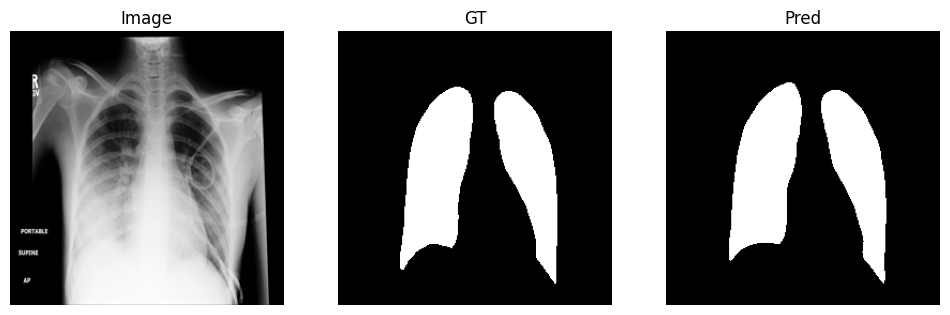

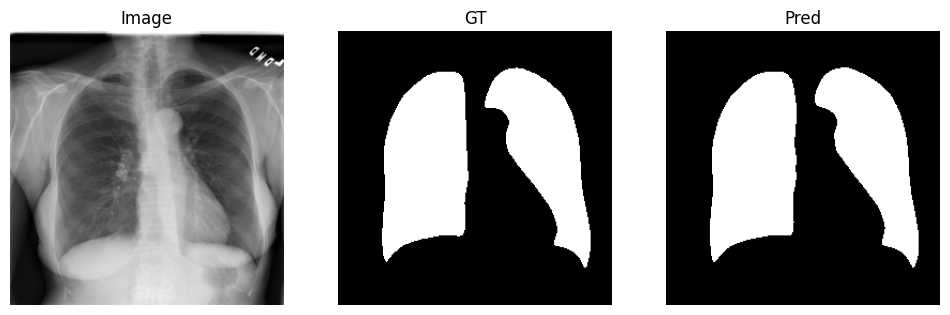

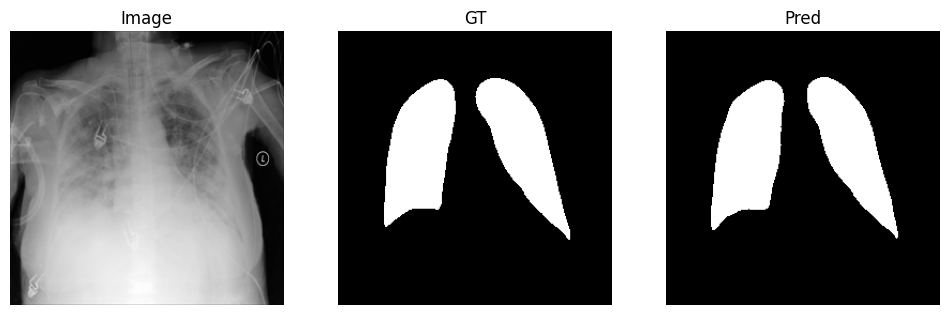

In [ ]:
import matplotlib.pyplot as plt
import random

def show_pred(ds, n=3):
    model.eval()
    for _ in range(n):
        idx = random.randint(0, len(ds)-1)
        x, y = ds[idx]

        with torch.no_grad():
            logits = model(x.unsqueeze(0).to(DEVICE))
            p = torch.sigmoid(logits).cpu()[0,0].numpy()

        img = x[0].numpy()
        gt  = y[0].numpy()
        pr  = (p > 0.5).astype("float32")

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title("Image"); plt.imshow(img, cmap="gray"); plt.axis("off")
        plt.subplot(1,3,2); plt.title("GT"); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1,3,3); plt.title("Pred"); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.show()

show_pred(test_ds, n=3)

In [ ]:
import os, glob, cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

INF_ROOT = "/content/data/Infection Segmentation Data/Infection Segmentation Data"
CLASSES = ["COVID-19", "Non-COVID", "Normal"]
IMG_EXTS = (".png", ".jpg", ".jpeg")

def map_dir(img_path, from_dir, to_dir):
    img_dir  = os.path.dirname(img_path)
    fname    = os.path.basename(img_path)
    target_dir = img_dir.replace(os.sep + from_dir, os.sep + to_dir)
    return os.path.join(target_dir, fname)

def collect_infection_items(split):
    items = []
    for cls in CLASSES:
        img_base = os.path.join(INF_ROOT, split, cls, "images")
        imgs = glob.glob(os.path.join(img_base, "**", "*.*"), recursive=True)
        imgs = [p for p in imgs if p.lower().endswith(IMG_EXTS)]
        for ip in imgs:
            lung_mp = map_dir(ip, "images", "lung masks")
            inf_mp  = map_dir(ip, "images", "infection masks")
            items.append((ip, lung_mp, inf_mp, cls))
    return items

train_items = collect_infection_items("Train")
val_items   = collect_infection_items("Val")
test_items  = collect_infection_items("Test")

print("Train items:", len(train_items), "Val items:", len(val_items), "Test items:", len(test_items))
print("Example:", train_items[0])

Train items: 3728 Val items: 932 Test items: 1166
Example: ('/content/data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/images/covid_467.png', '/content/data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/lung masks/covid_467.png', '/content/data/Infection Segmentation Data/Infection Segmentation Data/Train/COVID-19/infection masks/covid_467.png', 'COVID-19')


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

IMG_SIZE = 256

tfms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    ToTensorV2(),
])

In [ ]:
class InfectionSegDataset(Dataset):
    def __init__(self, items, tfms):
        self.items = items
        self.tfms = tfms

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, lung_path, inf_path, cls = self.items[idx]

        img  = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        lung = cv2.imread(lung_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            raise ValueError(f"Image read failed: {img_path}")
        if lung is None:
            raise ValueError(f"Lung mask read failed: {lung_path}")

        inf = cv2.imread(inf_path, cv2.IMREAD_GRAYSCALE)
        if inf is None:
            inf = np.zeros_like(img, dtype=np.uint8)

        lung = (lung > 127).astype(np.float32)
        inf  = (inf  > 127).astype(np.float32)

        img = img.astype(np.float32) / 255.0
        img = img * lung

        out = self.tfms(image=img, mask=inf)
        x = out["image"].float()
        y = out["mask"].float()

        if x.ndim == 2: x = x.unsqueeze(0)
        if y.ndim == 2: y = y.unsqueeze(0)

        return x, y

In [ ]:
BATCH_SIZE = 64

train_ds = InfectionSegDataset(train_items, tfms)
val_ds   = InfectionSegDataset(val_items, tfms)
test_ds  = InfectionSegDataset(test_items, tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

x, y = next(iter(train_loader))
print("Batch:", x.shape, y.shape, x.min().item(), x.max().item(), "pos_y:", y.sum().item())

Batch: torch.Size([64, 1, 256, 256]) torch.Size([64, 1, 256, 256]) 0.0 0.9803921580314636 pos_y: 340907.0


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

model2 = UNet(base=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()

def dice_coef(probs, targets, thresh=0.5, eps=1e-7):
    preds = (probs > thresh).float()
    targets = (targets > 0.5).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    denom = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3))
    dice = (2*inter + eps) / (denom + eps)
    return dice.mean().item()

def iou_coef(probs, targets, thresh=0.5, eps=1e-7):
    preds = (probs > thresh).float()
    targets = (targets > 0.5).float()
    inter = (preds * targets).sum(dim=(1,2,3))
    union = preds.sum(dim=(1,2,3)) + targets.sum(dim=(1,2,3)) - inter
    iou = (inter + eps) / (union + eps)
    return iou.mean().item()

Device: cuda


In [ ]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
use_cuda = (DEVICE == "cuda")
scaler = torch.amp.GradScaler("cuda", enabled=use_cuda)

def run_epoch2(loader, train=True):
    model2.train(train)
    total_loss, total_dice, total_iou = 0.0, 0.0, 0.0

    for x, y in tqdm(loader, leave=False):
        x = x.to(DEVICE, non_blocking=True)
        y = y.to(DEVICE, non_blocking=True)

        if train:
            optimizer.zero_grad(set_to_none=True)

        with torch.amp.autocast("cuda", enabled=use_cuda):
            logits = model2(x)
            loss = loss_fn(logits, y)

        if train:
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        probs = torch.sigmoid(logits).detach()
        total_loss += loss.item()
        total_dice += dice_coef(probs, y)
        total_iou  += iou_coef(probs, y)

    n = len(loader)
    return total_loss/n, total_dice/n, total_iou/n

best_dice = 0.0
for epoch in range(1, 31):
    tr_loss, tr_dice, tr_iou = run_epoch2(train_loader, train=True)
    va_loss, va_dice, va_iou = run_epoch2(val_loader, train=False)

    print(
        f"Epoch {epoch:02d} | "
        f"train loss {tr_loss:.4f} dice {tr_dice:.4f} iou {tr_iou:.4f} | "
        f"val loss {va_loss:.4f} dice {va_dice:.4f} iou {va_iou:.4f}"
    )

    if va_dice > best_dice:
        best_dice = va_dice
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Prac_3/best_unet_infection.pth")
        print(" Saved best infection model to Drive")

Epoch 01 | train loss 0.3052 dice 0.3505 iou 0.3111 | val loss 0.2609 dice 0.5138 iou 0.5137
 Saved best infection model to Drive


Epoch 02 | train loss 0.1711 dice 0.4123 iou 0.3664 | val loss 0.2160 dice 0.5146 iou 0.5146
 Saved best infection model to Drive


Epoch 03 | train loss 0.1403 dice 0.4500 iou 0.3974 | val loss 0.1323 dice 0.4391 iou 0.3837


Epoch 04 | train loss 0.1171 dice 0.5444 iou 0.4880 | val loss 0.1695 dice 0.4471 iou 0.3948


Epoch 05 | train loss 0.1038 dice 0.6293 iou 0.5710 | val loss 0.4169 dice 0.5157 iou 0.5152
 Saved best infection model to Drive


Epoch 06 | train loss 0.1007 dice 0.6431 iou 0.5860 | val loss 0.3270 dice 0.5136 iou 0.5136


Epoch 07 | train loss 0.0922 dice 0.6782 iou 0.6211 | val loss 0.3404 dice 0.5146 iou 0.5146


Epoch 08 | train loss 0.0853 dice 0.7329 iou 0.6759 | val loss 0.2080 dice 0.4186 iou 0.3676


Epoch 09 | train loss 0.0867 dice 0.7272 iou 0.6700 | val loss 0.2043 dice 0.4167 iou 0.3665


Epoch 10 | train loss 0.0844 dice 0.7381 iou 0.6807 | val loss 0.1334 dice 0.5878 iou 0.5619
 Saved best infection model to Drive


Epoch 11 | train loss 0.0770 dice 0.7687 iou 0.7111 | val loss 0.3373 dice 0.5164 iou 0.5156


Epoch 12 | train loss 0.0754 dice 0.7707 iou 0.7144 | val loss 0.0954 dice 0.7181 iou 0.6643
 Saved best infection model to Drive


Epoch 13 | train loss 0.0809 dice 0.7654 iou 0.7080 | val loss 0.1889 dice 0.4793 iou 0.4290


Epoch 14 | train loss 0.0814 dice 0.7478 iou 0.6895 | val loss 0.2766 dice 0.5196 iou 0.5174


Epoch 15 | train loss 0.0732 dice 0.7939 iou 0.7369 | val loss 0.1652 dice 0.4852 iou 0.4351


Epoch 16 | train loss 0.0723 dice 0.7881 iou 0.7318 | val loss 0.1849 dice 0.5141 iou 0.4641


Epoch 17 | train loss 0.0767 dice 0.7730 iou 0.7162 | val loss 0.1955 dice 0.4340 iou 0.3841


Epoch 18 | train loss 0.0721 dice 0.7879 iou 0.7309 | val loss 0.2745 dice 0.5196 iou 0.5174


Epoch 19 | train loss 0.0724 dice 0.7873 iou 0.7309 | val loss 0.5348 dice 0.5146 iou 0.5146


Epoch 20 | train loss 0.0737 dice 0.7839 iou 0.7261 | val loss 0.3099 dice 0.5183 iou 0.5166


Epoch 21 | train loss 0.0713 dice 0.7845 iou 0.7277 | val loss 0.0690 dice 0.7792 iou 0.7247
 Saved best infection model to Drive


Epoch 22 | train loss 0.0707 dice 0.7864 iou 0.7304 | val loss 0.0983 dice 0.6562 iou 0.6055


Epoch 23 | train loss 0.0737 dice 0.7766 iou 0.7182 | val loss 0.1050 dice 0.6386 iou 0.5873


Epoch 24 | train loss 0.0698 dice 0.7951 iou 0.7373 | val loss 0.0702 dice 0.7892 iou 0.7278
 Saved best infection model to Drive


Epoch 25 | train loss 0.0716 dice 0.7817 iou 0.7239 | val loss 0.3343 dice 0.3342 iou 0.2844


Epoch 26 | train loss 0.0718 dice 0.7805 iou 0.7237 | val loss 0.3362 dice 0.3813 iou 0.3316


Epoch 27 | train loss 0.0693 dice 0.7894 iou 0.7313 | val loss 0.0637 dice 0.7875 iou 0.7289


Epoch 28 | train loss 0.0708 dice 0.7868 iou 0.7295 | val loss 0.3693 dice 0.5410 iou 0.5299


Epoch 29 | train loss 0.0677 dice 0.8075 iou 0.7511 | val loss 0.0674 dice 0.8060 iou 0.7542
 Saved best infection model to Drive


Epoch 30 | train loss 0.0676 dice 0.7987 iou 0.7421 | val loss 0.3047 dice 0.5292 iou 0.5231


In [ ]:
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

model2.load_state_dict(torch.load("/content/drive/MyDrive/Prac_3/best_unet_infection.pth", map_location=DEVICE))
model2.eval()

te_loss, te_dice, te_iou = run_epoch2(test_loader, train=False)
print(f"TEST | loss {te_loss:.4f} dice {te_dice:.4f} iou {te_iou:.4f}")

TEST | loss 0.0649 dice 0.7957 iou 0.7449


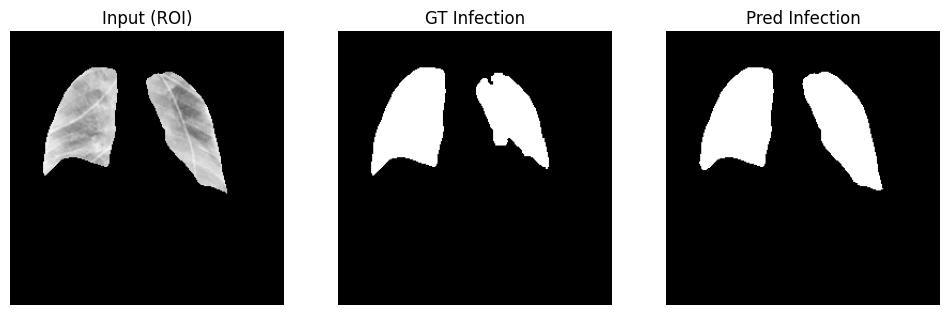

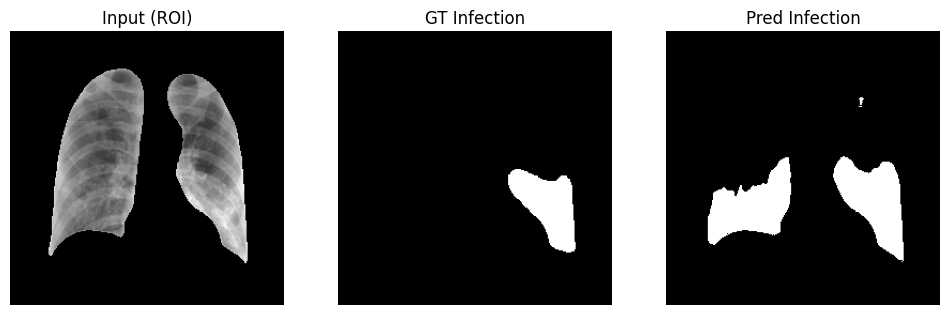

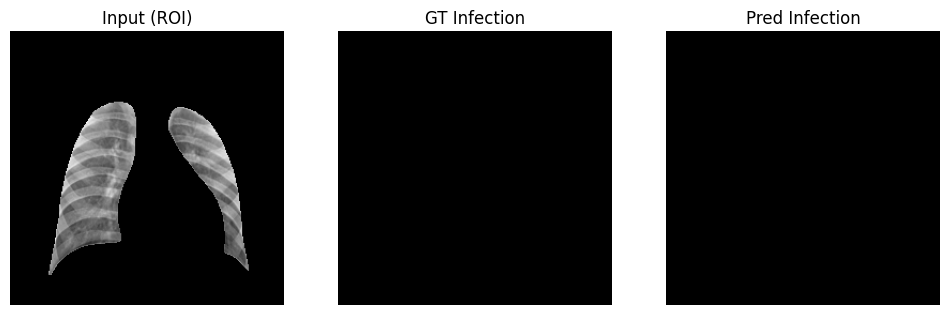

In [ ]:
import random, matplotlib.pyplot as plt

def show_pred_infection(ds, n=3):
    model2.eval()
    for _ in range(n):
        idx = random.randint(0, len(ds)-1)
        x, y = ds[idx]
        with torch.no_grad():
            p = torch.sigmoid(model2(x.unsqueeze(0).to(DEVICE)))[0,0].cpu().numpy()

        img = x[0].numpy()
        gt  = y[0].numpy()
        pr  = (p > 0.5).astype(np.float32)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1); plt.title("Input (ROI)"); plt.imshow(img, cmap="gray"); plt.axis("off")
        plt.subplot(1,3,2); plt.title("GT Infection"); plt.imshow(gt, cmap="gray"); plt.axis("off")
        plt.subplot(1,3,3); plt.title("Pred Infection"); plt.imshow(pr, cmap="gray"); plt.axis("off")
        plt.show()

show_pred_infection(test_ds, 3)